# Exercício 1 de Análise de Componentes Independentes em imagens


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.cluster.vq import whiten
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import entropy, chi2_contingency, shapiro
from scipy.misc import imread

%matplotlib inline
from evaluation import calculateNegentropy, kde_entropy, KLdivergence, resultsTable, plot_MutualInformation
from ICAfunctions import cichocki_Feedback, cichocki_Feedforward, NPCA_RLS

#Notes:
#SHAPIRO: The algorithm used is described in [R634] but censoring parameters as 
#        described are not implemented. For N > 5000 the W test statistic is 
#        accurate but the p-value may not be.

In [2]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

def rgb_ICA(ICA_method, mixturesRGB, learningRate):
    y = np.zeros(mixturesRGB.shape)
    
    [y[:, :, 0], Wr] = ICA_method(mixturesRGB[:, :, 0], learningRate)
    [y[:, :, 1], Wg] = ICA_method(mixturesRGB[:, :, 1], learningRate)
    [y[:, :, 2], Wb] = ICA_method(mixturesRGB[:, :, 2], learningRate)
    
    W = [Wr, Wg, Wb]
    
    return y, W
def read_rgb_image(folderPath, n_images = 2, n_channels = 3):
    X1 = imread(folderPath + '\\1_saida.jpg', flatten = False)
    X2 = imread(folderPath + '\\2_saida.jpg', flatten = False)
    
    mixtures = np.zeros((n_images, X1.shape[0]*X1.shape[1], n_channels), np.float64)

    mixtures[0, :, 0] = X1[:,:,0].flatten()
    mixtures[0, :, 1] = X1[:,:,1].flatten()
    mixtures[0, :, 2] = X1[:,:,2].flatten()
    
    mixtures[1, :, 0] = X2[:,:,0].flatten()
    mixtures[1, :, 1] = X2[:,:,1].flatten()
    mixtures[1, :, 2] = X2[:,:,2].flatten()   
    
    original_shape = X1.shape

    return mixtures, original_shape

def rebuildPicture(x, original_shape):
    rebuilt = np.zeros(original_shape, np.float64)
    rebuilt[:, :, 0] = np.reshape(x[:, 0], (original_shape[0], original_shape[1]))
    rebuilt[:, :, 1] = np.reshape(x[:, 1], (original_shape[0], original_shape[1]))
    rebuilt[:, :, 2] = np.reshape(x[:, 2], (original_shape[0], original_shape[1]))
    
    return rebuilt

In [3]:
learning_rate = 1e-6
n_images = 2

(2, 200000, 3)
(400, 500, 3)
(400, 500, 3)


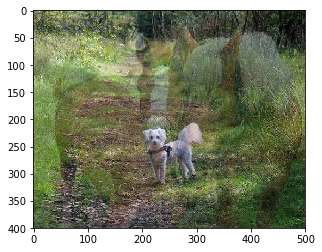

In [6]:
folderPath = 'E:\\OneDrive\\Documentos\\UFRJ\\Mestrado\\PEE\\ICA\\imagens\\base_imagens_ica\\1_run'
mixtures, original_shape = read_rgb_image(folderPath)
print(mixtures.shape)
print(original_shape)
picture = rebuildPicture(mixtures[0], original_shape)
print(picture.shape)
plt.imshow(-picture)

In [11]:
[yNPCA, WNPCA] = rgb_ICA(NPCA_RLS, mixtures, 0.9993)

Execution time: 76.43895554542542 seconds
Execution time: 71.68742251396179 seconds
Execution time: 74.11452341079712 seconds


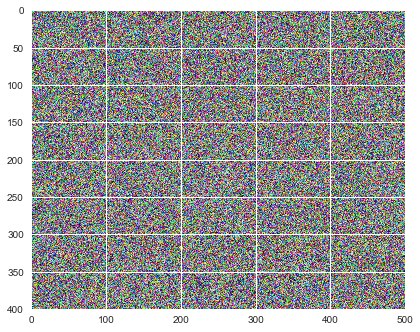

In [24]:
y = yNPCA
y[:, :, 0] = np.dot(WNPCA[0], mixtures[:, :, 0])
y[:, :, 1] = np.dot(WNPCA[1], mixtures[:, :, 1])
y[:, :, 2] = np.dot(WNPCA[2], mixtures[:, :, 2])
picture = rebuildPicture(y[1], original_shape)
plt.imshow(picture)

UnboundLocalError: local variable 'p_bins' referenced before assignment

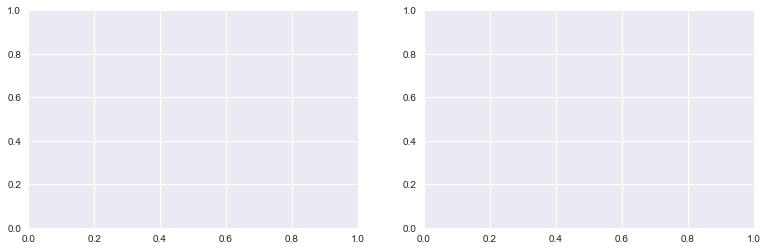

In [13]:
plot_MutualInformation(mixtures[:,:,0], y[:,:, 0], nbins = 100)

In [14]:
x = np.dot(WNPCA, mixtures)
plt.hist(x[0], bins = 256)
plt.show()

#print(np.amax(yNPCA[0]), np.amin(yNPCA[0]), np.mean(yNPCA[0]))

ValueError: shapes (3,2,2) and (2,200000,3) not aligned: 2 (dim 2) != 200000 (dim 1)

In [15]:
#reconstructed_yNPCA = np.reshape(np.dot(WNPCA, mixtures), (n_images, ) + original_shape)
#reconstructed_yNPCA = np.reshape(yNPCA, (n_images, ) + original_shape)


plt.figure(figsize = (8,8))
if len(original_shape) == 2:
    x, cdfx = image_histogram_equalization(reconstructed_yNPCA[0])
    print(x.shape, np.amax(x), np.amin(x), np.mean(x))
    plt.imshow(x, cmap = 'gray')

else:
    x = reconstructed_yNPCA
    #x = np.zeros((n_images, ) + original_shape)
    #for j in range(n_images):
    #    for i in range(original_shape[2]):
    #        x[j,:,:,i], cdfx = image_histogram_equalization(reconstructed_yNPCA[j,:,:,i])
    print(x.shape, np.amax(x), np.amin(x), np.mean(x))
    plt.imshow(x[0])

ValueError: shapes (3,2,2) and (2,200000,3) not aligned: 2 (dim 2) != 200000 (dim 1)

In [16]:
[y, WBack] = cichocki_Feedback(mixtures, learning_rate)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [17]:
reconstructed_yBack = np.reshape(np.dot(WBack, mixtures), (n_images, ) + original_shape)
plt.figure(figsize = (8,8))
if len(original_shape) == 2:
    x, cdfx = image_histogram_equalization(reconstructed_yBack[1])
    print(x.shape, np.amax(x), np.amin(x), np.mean(x))
    plt.imshow(x, cmap = 'gray')

else:
    x = np.zeros((n_images, ) + original_shape)
    for j in range(n_images):
        for i in range(original_shape[2]):
            x[j,:,:,i], cdfx = image_histogram_equalization(reconstructed_yBack[j,:,:,i])
    print(x.shape, np.amax(x), np.amin(x), np.mean(x))
    plt.imshow(x[0])

NameError: name 'WBack' is not defined

In [18]:
[y, WForward] = cichocki_Feedforward(mixtures, learning_rate)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [19]:
reconstructed_yForward = np.reshape(np.dot(WForward, mixtures), (n_images, ) + original_shape)
plt.figure(figsize = (12,12))
if len(original_shape) == 2:
    plt.imshow(reconstructed_yForward[0], cmap = 'gray')
else:
    plt.imshow(reconstructed_yForward[0])

NameError: name 'WForward' is not defined